<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA22/blob/main/python/C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Divided differences using sparse matrix

Import the usual modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

New module: sparse algebra

In [2]:
import scipy.sparse as sp

Function implementing the forward difference in sparse format

In [3]:
def forward_difference(a, b, N):
  h = (b-a)/N
 
  # Compute FD matrix as sparse using Compressed Sparse Row (CSR) format 
  data = [-np.ones(N+1), np.ones(N)]
  FD = sp.diags(data,[0,1], format="csr")
  return FD / h

In [4]:
a=0
b=1
N=5
FD = forward_difference(a, b, N)

In [5]:
print (FD)

  (0, 0)	-5.0
  (0, 1)	5.0
  (1, 1)	-5.0
  (1, 2)	5.0
  (2, 2)	-5.0
  (2, 3)	5.0
  (3, 3)	-5.0
  (3, 4)	5.0
  (4, 4)	-5.0
  (4, 5)	5.0
  (5, 5)	-5.0


In [6]:
print(FD.todense())

[[-5.  5.  0.  0.  0.  0.]
 [ 0. -5.  5.  0.  0.  0.]
 [ 0.  0. -5.  5.  0.  0.]
 [ 0.  0.  0. -5.  5.  0.]
 [ 0.  0.  0.  0. -5.  5.]
 [ 0.  0.  0.  0.  0. -5.]]


Use the FD to evaluate the derivative of $f(x)=\frac{x^2}{2}$

In [7]:
t = sym.var('t')
my_f = 0.5 * t**2
fsym = sym.lambdify(t, my_f )

a=0 
b=1
N = 100

# Evaluate FD matrix
FD = forward_difference(a, b, N)

# Values of the derivative at the 
# internal grid points
x=np.linspace(0,1,N+1)

%timeit u_x = FD.dot(fsym(x))[1:N]

# Print results
#print(u_x)

8.6 µs ± 254 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


**Exercise.** Find a way to evaluate execution time and compare full vs sparse exectution time

# Central finite differences in 1D

Poisson problem in 1D:

$-u''(x)=f(x) \quad \in (a,b)$

$u(a)=0, \quad u(b)=0$

We use the second central divided difference to approxima the second derivative.

Given $h>0$, 

$u''(x)≈\frac{u(x+h)-2u(x)+u(x-h)}{h^2}$

Function for second central matrix

In [8]:
def CD2(N):
  # Function defining nominator of
  # second central FD formula on a 
  # uniform grid in sparse CSR format
  data = [np.ones(N), -2 * np.ones(N+1), np.ones(N)]
  return sp.diags(data,[-1,0,1], format="csr")

In [9]:
N = 5
A = CD2(N)

print(A.todense())

[[-2.  1.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  1. -2.]]


Test problem:

$(a,b)=(0,\pi)$

u(x)=sin(x)

In [10]:
# Define right-hand side function
t = sym.var('t')
my_f = sym.sin(t)
rhs_f = sym.lambdify(t, my_f )

# Define exact solution
my_sol = sym.sin(t)
exact_sol = sym.lambdify(t, my_sol )

Define FD problem:

for $h=(b-a)/N$

$ A U = - h^2 F $

with $A$ the nominator of CD formula.

In [11]:
# Problem domain
a = 0
b= np.pi

# Size of grid
N = 20
h = (b-a)/N

# Grid
x = np.linspace(a,b,N+1)

# CD matrix
A = CD2(N)

# Right-hand side
F = - h**2 * rhs_f(x[1:-1])

# Homogeneous Dirichlet boundary conditions
A = A[1:-1,1:-1]


Import solver

In [12]:
from scipy.sparse.linalg import spsolve

Solve problem and print result

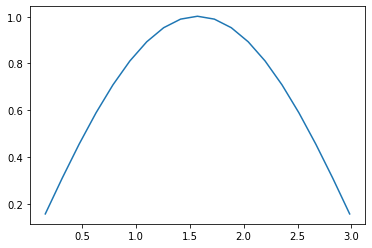

In [13]:
# Compute solution at internal nodes
FD_sol = spsolve(A,F)

# plot solution
plt.plot(x[1:-1],FD_sol)

In [14]:
# print max error

print(np.max(np.abs(FD_sol-exact_sol(x[1:-1]))))

0.002058706764533902


**Exercise 1.** test for convergence and plot convergence plot

We repeat what done before for increasingly higher values of N, then plot the error and see if it goes to 0.

In [15]:
import time

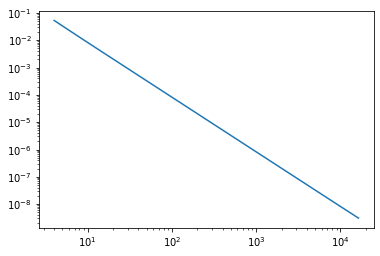

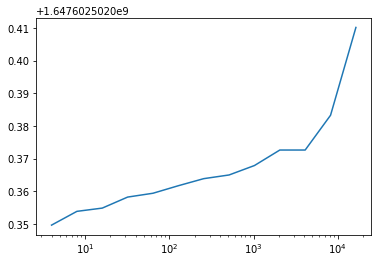

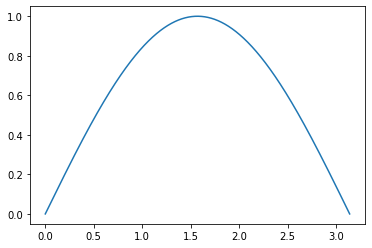

In [33]:
# Define right-hand side function
t = sym.var('t')
my_f = sym.sin(t)
rhs_f = sym.lambdify(t, my_f )

# Define exact solution
my_sol = sym.sin(t)
exact_sol = sym.lambdify(t, my_sol )

# Problem domain
a = 0
b= np.pi

Nvals=[]
errors=[]
times=[]

for i in range(2,15):
    # Size of grid
    N=2**i
    Nvals.append(N)
    h = (b-a)/N
    # Grid
    x = np.linspace(a,b,N+1)
    # CD matrix
    A = CD2(N)
    # Right-hand side
    F = - h**2 * rhs_f(x[1:-1])
    # Homogeneous Dirichlet boundary conditions
    A = A[1:-1,1:-1]
    # Compute solution at internal nodes
    FD_sol = spsolve(A,F)
    error=np.max(np.abs(FD_sol-exact_sol(x[1:-1])))
    errors.append(error)
    times.append(time.time())
plt.loglog(Nvals,errors)
plt.show()
plt.semilogx(Nvals,times)
plt.show()
plt.plot(x[1:-1],FD_sol)

**Exercise 2.** Solve the problem with nonhomogeneous Dirichlet conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=\frac{1}{2}$

**Exercise 3.** Solve the problem with (homogeneous) Neumann conditions:

$-\alpha u''(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u'(b)=0$

For example, you could fix: $(a,b)=(0,\pi/2)$, solution $u$ as before, $\alpha=1$.

**Exercise 4.** Solve the reaction-advection-diffusion problem (still with central differences):

$-\alpha u''(x)+\beta u'(x)+\gamma u(x)=f(x) \quad \in (a,b)$

$u(a)=u_a, \quad u(b)=u_b$


**Exercise 5.** Now take any of the problems above, but this time with data such that you do not know the exact solution. How would you test the order of convergence of the FD method?

**Exersie 6.** Consider again the problem from Exercise 4.

Fix $a=0$, $b=1$, $u_a=1$, $u_b=0$ $f=0$.

Try first with $\alpha=\beta=\gamma=1$ and plot the solution.

Next, try with $\alpha=0.01$, and $\beta=1$, $\gamma=0$. What happens? Can you explain?